# Computer Vision (911.908)

## <font color='crimson'>Data handling</font>

An important aspect when implementing neural network models (in PyTorch, and in general) is **data handling**, as in most cases, your data will not fit into memory (specifically, if you are working with GPU's) at once. 

**Changelog**:
- *Sep. 2022*: adaptations to PyTorch v1.12.1

--- 

## Content

- [Introduction](#Introduction)
- [Writing your on dataset](#Writing-your-own-dataset)
- [Handling custom image datasets](#Handling-custom-image-datasets)
- [Image transforms](#Image-transforms)

In [2]:
# imports

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torchvision

import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

---

## Introduction

For instance, the following will not work well when your dataset is **huge**, especially once you start working on the GPU. Admittedly, MNIST is not a problem because the images are so small and single-channel :)

In [3]:
# Download the MNIST digit dataset
train_set = torchvision.datasets.MNIST(
    '../data/mnist/',
    train = 
    True, 
    download = True)

The instance `train_set` of `torchvision.datasets.MNIST` already contains all images as a tensor (in `train_set.data`).

In [9]:
print(type(train_set.data))
print(train_set.data.dtype)

<class 'torch.Tensor'>
torch.uint8


The tensor is of size `[60000,28,28]`, so 60,000 images of size $28 \times 28$ (as I said earlier, MNIST is grayscale, so single-channel). To make this single-channel nature more explicit, we expand the tensor into shape `[60000,1,28,28]`.

In [10]:
X = train_set.data.view(-1,1,28,28).float()
X.size()

torch.Size([60000, 1, 28, 28])

Lets visualize the first image in the dataset:

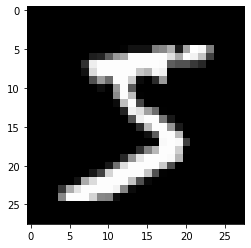

In [11]:
plt.imshow(X[0].numpy()[0,:,:], cmap='gray');

---

## Writing your own dataset

Writing your own dataset class is quite easy. In fact, you only have to derive a class from `torch.utils.data.Dataset` and overwrite the

- `__len__`    
and
- `__getitem__`

class methods. The first method returns the size of the dataset, the second provides the $i$-th item from the dataset. Below is an example of a dataset which stores 100 floating point numbers from 0 to 99, internally stored as a numpy array (this is a design choice obviously; nothing prevents you from already storing data as PyTorch tensors).

In [15]:
class Numbers(torch.utils.data.Dataset):
    def __init__(self):
        self.samples = np.zeros((100,1), dtype=np.float32) # numpy array of size (100,1) of ALL ZEROS
        self.samples[:,0] = list(range(100)) # fill numpy array with sequence 0,...,99

    def __len__(self):
        # return size of the dataset
        return self.samples.shape[0]

    def __getitem__(self, idx):
        # return the idx-th sample
        return self.samples[idx,:]

dataset = Numbers()

print('99-th item in dataset:', dataset[99], type(dataset[99]))
print('Dataset size: ', len(dataset))

99-th item in dataset: [99.] <class 'numpy.ndarray'>
Dataset size:  100


One important advantage of this approach is that you can immediately start using the `torch.utils.data.DataLoader` which already provides easy **batch processing** and shuffling capabilities and you can easily iterate.

You can remember, that essentially everything that you do in the context of learning with neural networks, you do in **chunks** of data, aka **mini-batches**.

In [21]:
dl = DataLoader(dataset, batch_size=5)

print('If we process our data in chunks of 5, we have:', len(dl), 'of them.')

# iterate over DataLoader
for i,x in enumerate(dl):
    print('{}-th batch is of size {} and type {}'.format(i,x.size(),type(x)))

If we process our data in chunks of 5, we have: 20 of them.
0-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
1-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
2-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
3-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
4-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
5-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
6-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
7-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
8-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
9-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
10-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
11-th batch is of size torch.Size([5, 1]) and type <class 'torch.Tensor'>
12-th batch is of size torch.Size([5, 1]) and type <class 'tor

As we can see, the `torch.utils.data.DataLoader` already takes care of converting everything to `torch.Tensor`. 

Importantly, the original ordering of the samples in our `Numbers` class remains the same. Setting `shuffle=True` when constructing the `DataLoader` shuffles the data and then splits the data up into `batch_size` chunks.

In [24]:
dl_wo_shuffle = DataLoader(dataset, batch_size=5, shuffle=False)
print(next(iter(dl_wo_shuffle)))
dl_w_shuffle = DataLoader(dataset, batch_size=5, shuffle=True)
print(next(iter(dl_w_shuffle)))

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])
tensor([[99.],
        [91.],
        [50.],
        [84.],
        [41.]])


---

## Handling custom image datasets 

Most of the time when working with image datasets, you have images in a folder structure. In that case PyTorch already provides an appropriate class, called `torchvision.datasets.ImageFolder`.

In case your data is structured as

```
data/class_A/img0.jpg
data/class_A/img1.jpg
...
data/class_B/img1.jpg
...
```

you just have to specify the root folder and the `ImageFolder` class will automatically provide access to the images and the labels (numerated starting from `0`).




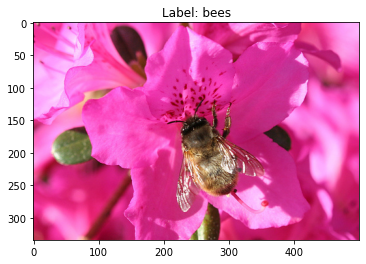

In [25]:
import PIL
%matplotlib inline
import matplotlib.pyplot as plt

ds = ImageFolder('../data/hymenoptera_data/train/')

# ds[0] returns the first data entry, in particular
# a tuple of (img, label)
img = ds[130][0] 
lab = ds[130][1]

plt.imshow(ds[130][0])
plt.title('Label: {}'.format(ds.classes[lab]));

---

## Image transforms

You might also want to apply certain **transformations** as a pre-processing step. E.g., you might want to flip the image, normalize it, etc. Many transforms are already implemented in PyTorch and can be accessed via `torchvision.transforms`. 

Below is a simple example, where we perform a random vertical and horizontal flip (via `torchvision.transforms.RandomVerticalFlip` and `torchvision.transforms.RandomHorizontalFlip`) and then convert the `PIL` image (which is the standard library for handling images in PyTorch) to a tensor (via `torchvision.transforms.ToTensor`) with values in $[0,1]$.

In [26]:
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomVerticalFlip(),   
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

In [27]:
ds_t = ImageFolder(
    '../data/hymenoptera_data/train/', 
    transform=data_transform)

torch.float32
torch.Size([3, 334, 500])
tensor([[0.9922, 0.9882, 0.9882, 0.9922, 0.9961],
        [0.9961, 0.9922, 0.9922, 0.9961, 1.0000],
        [0.9961, 0.9961, 1.0000, 0.9961, 1.0000],
        [1.0000, 0.9961, 0.9961, 0.9961, 1.0000],
        [0.9961, 1.0000, 0.9961, 1.0000, 0.9961]])


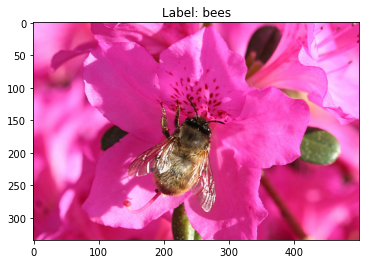

In [30]:
img = ds_t[130][0] 
lab = ds_t[130][1]
print(img.dtype)      # data type: now a float32 tensor
print(img.size())     # size of the image
print(img[0,0:5,0:5]) # print some values of the first color channel (should be in [0,1])

plt.imshow(img.permute(1,2,0).numpy())
plt.title('Label: {}'.format(ds.classes[lab]));

---

## Resources

A great tutorial for writing datasets and using the dataloader can be found [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).